In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
def suffix_dupIndex(df, add_one_subfix=False):
    dup_labels = df.index.duplicated(keep=False)
    dup_count = dup_labels.sum()
    if dup_count > 0:
        new_labels = []
        label_counts = {}
        for i, label in enumerate(df.index):
            if label in label_counts:
                label_counts[label] += 1
                new_labels.append(f"{label}_{label_counts[label]+1}")
            else:
                label_counts[label] = 0
                if dup_labels[i] or add_one_subfix:
                    new_labels.append(f"{label}_{label_counts[label]+1}")
                else:
                    new_labels.append(label)
        # df.index = new_labels
        return new_labels
    
def getEntPath(section, data_split):
    file_dir = str((Path().absolute()).parents[0]) + f"/PL-Marker/_statistics_data/{section}"
    ent_path = f"{file_dir}/{data_split}_ent.csv"
    rel_path = f"{file_dir}/{data_split}_rel.csv"
    return ent_path, rel_path

# Import data

In [3]:
data_df = {}
for data_split in ["train", "val"]:
    ent_path, rel_path = getEntPath("summary", data_split)
    data_df[data_split] = pd.read_csv(ent_path, index_col=0)
data_df["train"].head()

,paper_id,summary,Method,OtherScientificTerm,Task,Generic,Material,Metric
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,This paper investigates kernel ridge - less re...,3,2,1,0,0,0
0,SP:b80bc890180934092cde037b49d94d6e4e06fad9,This paper presents a novel way of making full...,5,4,0,1,0,0
0,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,This paper proposes a new framework that compu...,2,2,1,6,0,0
0,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This work proposes a deep reinforcement learni...,4,1,3,2,0,0
0,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,This paper proposes 3 deep generative models b...,7,3,4,2,0,0


# KNN Clustering

In [4]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'
from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
def get_token(sentence, get_len=True):
    tokens = tokenizer.encode(
        sentence, 
        # padding='max_length',  
        # max_length=args.max_input, 
        truncation=True, 
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    if get_len: return tokens.shape[1]
    else: return tokens

/home/nopphawann/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class KNN_model:
    def __init__(self, df_train, k):
        X = self.tranform_input(df_train)
        self.k = k
        self.model = KMeans(n_clusters=self.k, random_state=42).fit(X)
        
    def tranform_input(self, df):
        return np.array([list(df[col]) for col in ['Method', 'Task', 'Material', 'Metric']]).T
    
    def get_cluster(self, df):
        X = self.tranform_input(df)
        labels = self.model.predict(X)
        # self.cluster_df = df.copy()
        # self.cluster_df['cluster'] = labels
        return labels
    
    def plot_entities(self, df, title=None):
        if title==None: title='Number of entities'
        df['cluster'] = self.get_cluster(df)
        df_boxplot = pd.DataFrame()
        for i in range(self.k):
            df_boxplot_ = pd.melt(df[df['cluster']==i], value_vars=['Task', 'Material', 'Method', 'Metric'], var_name="entity_type")
            df_boxplot_['cluster'] = i+1
            df_boxplot = pd.concat([df_boxplot, df_boxplot_])
        df_boxplot.rename(columns={'value': "No. of Ent."}, inplace=True)
        self.get_boxplot(
            df_boxplot, 
            x='entity_type', 
            y='No. of Ent.', 
            graph_title=title,
            hue='cluster'
        )
        
    def plot_tokenlen(self, df, title=None):
        if title==None: title='Number of entities'
        df['token_len'] = df['summary'].apply(get_token)
        self.get_boxplot(
            df, 
            x='cluster', 
            y='token_len', 
            graph_title=title,
        )
        return df
        
    
    def get_boxplot(self, df, x, y, graph_title, hue=None, hue_title=None):
        plt.rcParams["figure.figsize"] = [5, 5]
        plt.rcParams["figure.autolayout"] = True
        sns.boxplot(x=x, y=y, hue=hue, data=df, palette="Set1")
        plt.title(graph_title)
        if hue!=None:
            if hue_title==None: hue_title = hue
            plt.legend(bbox_to_anchor=(1.05, 1), title=hue, loc='upper left', borderaxespad=0)
        plt.show()
        
    def export_cluster(self, df, data_split, exp_dir=""):
        df['cluster'] = self.get_cluster(df)
        df = df[["paper_id", "summary", "cluster"]]
        df['sum_id'] = suffix_dupIndex(df.set_index("paper_id"), add_one_subfix=True)
        filename = f"KNN-k3-{data_split}"
        ver  = -1
        for file in sorted(os.listdir()):
            if file[:len(filename)]==filename:
                f = file.split(".")[0].split("-")[-1]
                if f[0]=='v' and f[1:].isdigit():
                    ver = max(ver, int(f[1:]))
        exp_path = f"{exp_dir}{filename}-v{ver+1}.csv"
        
        df.to_csv(exp_path, index=0)
        print(f"Saved {len(df)} sample to {exp_path}")
        
    def get_num_paper(self, df):
        df["cluster"] = model.get_cluster(df)
        df_count = df[["paper_id", "cluster"]].groupby("cluster").count()
        df_count.rename(columns={"paper_id": "num_paper"}, inplace=True)
        df_count["num_paper(%)"] = df_count["num_paper"]/df_count["num_paper"].sum()*100
        return df_count
        


In [6]:
model = KNN_model(data_df["train"], k=3)

/home/nopphawann/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
model.export_cluster(data_df["train"], "train")

Saved 18934 sample to KNN-k3-train-v0.csv


/tmp/ipykernel_198696/1829942577.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sum_id'] = suffix_dupIndex(df.set_index("paper_id"), add_one_subfix=True)


In [8]:
model.export_cluster(data_df["val"], "val")

Saved 3604 sample to KNN-k3-val-v0.csv


/tmp/ipykernel_198696/1829942577.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sum_id'] = suffix_dupIndex(df.set_index("paper_id"), add_one_subfix=True)


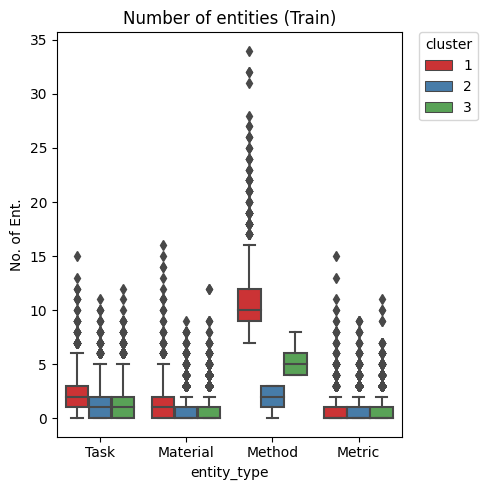

In [9]:
model.plot_entities(data_df["train"], title="Number of entities (Train)")

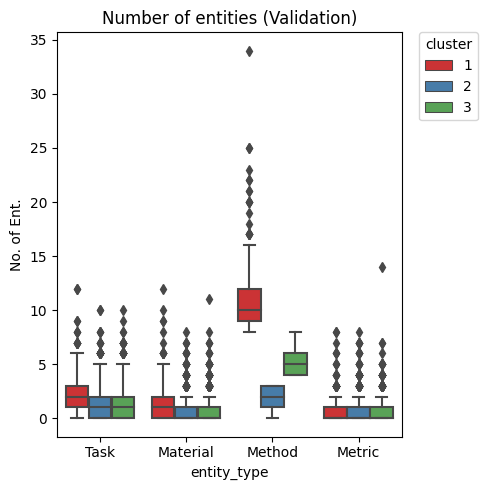

In [40]:
model.plot_entities(data_df["val"], title="Number of entities (Validation)")

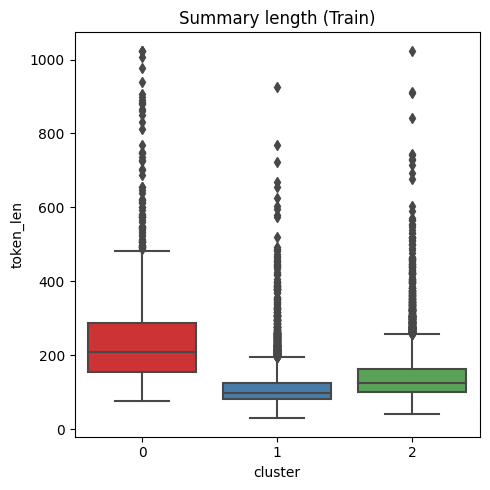

In [44]:
tokens = model.plot_tokenlen(data_df["train"], title='Summary length (Train)')

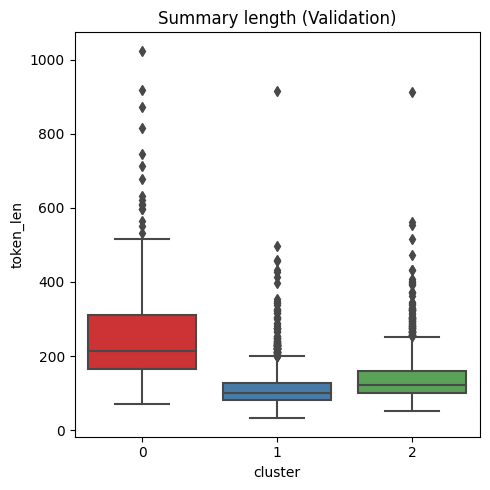

In [45]:
tokens = model.plot_tokenlen(data_df["val"], title='Summary length (Validation)')

In [52]:
for i in range(3):
    token_cluster = df[df['cluster']==i]['token_len']
    output_len = token_cluster.quantile(.999)
    max_len = token_cluster.max()
    mean_len = token_cluster.mean()
    print(i, output_len, max_len, mean_len)

0 992.6240000000008 1024 259.18518518518516
1 468.22200000000885 915 113.0190531177829
2 556.9820000000011 913 138.93142857142857


In [80]:
model.get_num_paper(data_df["train"])

,num_paper,num_paper(%)
cluster,,
0,1621,8.561318
1,8818,46.572304
2,8495,44.866378


In [81]:
model.get_num_paper(data_df["val"])

,num_paper,num_paper(%)
cluster,,
0,297,8.240844
1,1732,48.057714
2,1575,43.701443
